In [1]:
# Chapter23
# 23.1 Exampleクラス
# 22.4 minkowski distance
def minkowskiDist(v1, v2, p):
    """ v1とv2は長さの等しい数値配列であるとする
        v1とv2の、p次のミンコウスキ距離を返す。
        p = 1: マンハッタン距離
        p = 2: ユークリッド距離"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i]-v2[i])**p
    return dist**(1/p)

In [2]:
class Example(object):

    def __init__(self, name, features, label = None):
        """ name: string
            features: floatのリスト"""
        self.name = name
        self.features = features
        self.label = label
    
    # 次元数
    def dimensionality(self):
        return len(self.features)

    def getFeatures(self):
        return self.features[:] # コピーを返却
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    # ユークリッド距離を返す
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(),2)
    
    def __str__(self):
        return self.name + ':' + str(self.features) + ':' + str(self.label)

In [3]:
# 23.2 Clusterクラス
class Cluster(object):

    def __init__(self, examples):
        """examples: Exampleの空でないリスト"""
        self.examples = examples
        self.centroid = self.computeCentroid()
    
    def update(self, examples):
        """examples: Exampleの空でないリスト
           examplesを更新し、重心の変化の総量を返す"""
        oldCentroid = self.centroid
        self.examples = examples
        self.centroid = self.computeCentroid()
        return oldCentroid.distance(self.centroid)
    
    def computeCentroid(self):
        vals = pylab.array([0.0]*self.examples[0].dimensionality())
        for e in self.examples: # 平均を計算
            vals += e.getFeatures()
        centroid = Example('centroid', vals/len(self.examples))
        return centroid
    
    def getCentroid(self):
        return self.centroid
    
    def variability(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2 # クラスタ中心との距離を2乗
        return totDist
    
    def members(self):
        for e in self.examples:
            yield e
    
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster with centroid' + str(self.centroid.getFeatures()) + 'contains:\n'
        for e in names:
            result = result + e + ', '
        return result[:-2] # 最後にあるコンマ・スペースを除去

In [4]:
# 23.4
import random
import pylab

def kmeans(examples, k, verbose = False):
    # 初期のk個のランダムな重心を選択
    # それぞれの重心に対してクラスタを形成
    initialCentroids = random.sample(examples, k) # examplesからk個取得
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e]))
    
    # 重心が変化しなくなるまで繰り返す
    converged = False # 収束判定
    numIterations = 0
    while not converged:
        numIterations += 1
        # k個の空のリストからなるリストを作成する
        newClusters = []
        for i in range(k):
            newClusters.append([])
        
        # 標本それぞれeについて
        for e in examples:
            # eに最も近い重心を見つける
            smallestDistances = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1,k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistances:
                    smallestDistances = distance
                    index = i
            # 適切なクラスタの標本リストにeを加える
            newClusters[index].append(e)
        
        for c in newClusters: # 空のクラスタを避ける
            if len(c) == 0:
                raise ValueError('Empty Cluster')
        
        # クラスタを更新する: 重心が変化しているかチェック
        converged = True
        for i in range(k):
            if clusters[i].update(newClusters[i]) > 0.0:
                convarged = False
        if verbose:
            print('Iteration #' + str(numIterations))
            for c in clusters:
                print(c)
            print('') # 空行を追加
    return clusters

In [5]:
# 23.3 最適なk-meansクラスタリングの探索
def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variability()
    return totDist

def trykmeans(examples, numClusters, numTrials, verbose=False):
    """kmeans関数をnumTrials回呼び出し、
       最も類似性が小さいクラスタリングを返す"""
    best = kmeans(examples, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    trial = 1
    while trial < numTrials:
        try:
            clusters = kmeans(examples, numClusters, verbose)
        except ValueError:
            continue # 失敗したらもう一度
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
        trial += 1
    return best

In [6]:
# 23.5
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix + str(s),[x,y]))
    return samples

def plotSamples(samples, marker):
    xVals, yVals = [],[]
    for s in samples:
        x = s.getFeatures()[0] # Feature: (x,y)
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(),xy=(x,y),xytext=(x+0.13,y-0.07),fontsize='x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)

def contrivedTest(numTrials, k, verbose=False):
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean,xSD, yMean, ySD, n, 'A')
    plotSamples(d1Samples,'k^')
    d2Samples = genDistribution(xMean+3,xSD, yMean+1, ySD, n, 'B')
    plotSamples(d2Samples,'ko')
    clusters = trykmeans(d1Samples+d2Samples, k, numTrials, verbose)
    print('Final result')
    for c in clusters:
        print('',c)

Iteration #1
Cluster with centroid[6.60204323 5.37010268]contains:
B0, B1, B2, B3, B4, B5, B6, B8, B9
Cluster with centroid[3.41045206 5.1818538 ]contains:
A0, A1, A2, A3, A4, A5, A6, A7, A8, A9, B7

Final result
 Cluster with centroid[6.60204323 5.37010268]contains:
B0, B1, B2, B3, B4, B5, B6, B8, B9
 Cluster with centroid[3.41045206 5.1818538 ]contains:
A0, A1, A2, A3, A4, A5, A6, A7, A8, A9, B7


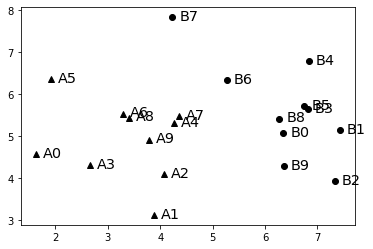

In [7]:
contrivedTest(1,2,True)

Final result
 Cluster with centroid[6.45160978 6.38752935]contains:
B1, B2, B3, B4, B5, B6, B8, B9
 Cluster with centroid[3.33925598 5.69592867]contains:
A0, A1, A2, A3, A4, A5, A6, A7, A8, A9, B0, B7


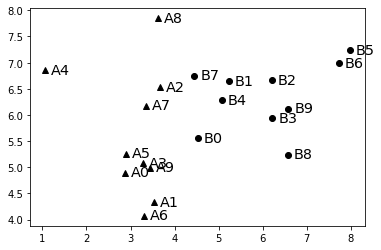

In [8]:
contrivedTest(50,2,False)

In [9]:
# 23.7
def contrivedTest2(numTrials, k, verbose=False):
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 8
    d1Samples = genDistribution(xMean,xSD,yMean,ySD,n,'A')
    plotSamples(d1Samples,'k^')
    d2Samples = genDistribution(xMean+3,xSD,yMean,ySD,n,'B')
    plotSamples(d2Samples,'ko')
    d3Samples = genDistribution(xMean,xSD,yMean+3,ySD,n,'C')
    plotSamples(d3Samples,'kx')
    clusters = trykmeans(d1Samples + d2Samples + d3Samples, k, numTrials, verbose)
    pylab.ylim(0,11)
    print('Final result has dissimilarity', round(dissimilarity(clusters),3))
    for c in clusters:
        print('',c)

Final result has dissimilarity 58.357
 Cluster with centroid[2.91053977 7.17555181]contains:
A0, A1, A6, A7, C0, C1, C2, C3, C4, C5, C6, C7
 Cluster with centroid[5.01317153 4.86132515]contains:
A2, A3, A4, A5, B0, B1, B2, B3, B4, B5, B6, B7


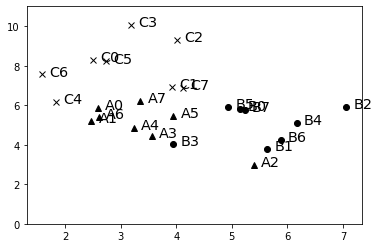

In [10]:
contrivedTest2(40,2)

Final result has dissimilarity 31.703
 Cluster with centroid[3.1184096  5.23970308]contains:
A0, A1, A3, A4, A5, A6, B1
 Cluster with centroid[3.21286439 8.37561648]contains:
A2, C0, C1, C2, C3, C4, C5, C6, C7
 Cluster with centroid[6.20443651 4.51485895]contains:
A7, B0, B2, B3, B4, B5, B6, B7


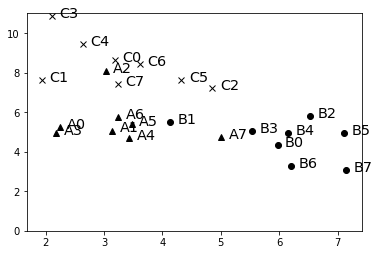

In [11]:
contrivedTest2(40,3)

Final result has dissimilarity 16.577
 Cluster with centroid[2.5953652  4.88433865]contains:
A0, A1, A3, A5, A6, A7
 Cluster with centroid[1.28537046 8.85658058]contains:
C1, C3
 Cluster with centroid[3.55078898 8.10131268]contains:
C0, C2, C6
 Cluster with centroid[6.52454157 5.35157143]contains:
B1, B3, B7
 Cluster with centroid[4.64163459 5.17981692]contains:
A4, B0, B2, B4, B5, B6
 Cluster with centroid[1.97476276 7.06553603]contains:
A2, C4, C5, C7


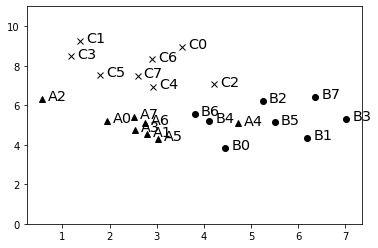

In [12]:
contrivedTest2(40,6)

### memo
- contrivedTest(40,6)が最も相違性が小さい。⇒最善のクラスタリングを意味しているわけではない。
    - 線形回帰の多項式の次数を上げることによってデータによりフィットするような複雑なモデルができたことと同じ意味。未知データに対しての予測が貧弱になってしまう。
- 正しいkを選択することは、線形回帰の適切な次数を選択することと同じ。
    - 例えば、m個なる分布から生じたデータということが事前にわかっていればそれをkの決定に利用できる。
    - kの決定方法も存在する。

In [22]:
# ファイルの読み込みと処理
def readMammalData(fName):
    dataFile =open(fName,'r')
    numFeatures= 0
    #ファイルの先頭の処理
    for line in dataFile:
        if line[0:6] =='#Label': #特徴の終了を表す
            break
        if line[0:5] != '#Name':
            numFeatures += 1

    # featureVals, speciesName,とlabelListの生成
    featureVals, speciesNames, labelList = [],[],[]
    for i in range(numFeatures):
        featureVals.append([])
    
    #コメント後の、行ごとの処理
    for line in dataFile:
        #改行の除去; その分割
        dataLine = line[:-1].split(',')
        speciesNames.append(dataLine[0])
        classLabel = dataLine[-1]
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))
    
    # 特徴ベクトルを含むリストを作るためにfeatureValsを使う
    # それぞれの哺乳類について
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

def buildMammalExamples(featureList, labelList, speciesNames):
    examples = []
    for i in range(len(speciesNames)):
        features = pylab.array(featureList[i])
        example = Example(speciesNames[i], features, labelList[i])
        examples.append(example)
    return examples

In [38]:
# 23.10 動物のクラスタリング
def testTeeth(numClusters, numTrials):
    features, labels, species = readMammalData('practice_Ch23.txt')
    examples = buildMammalExamples(features,labels,species)
    bestClustering = trykmeans(examples, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ','
        print('\n' + names[:-2]) # 続くコンマとスペースを取り除く
        herbivores, carnivores, omnivores = 0,0,0
        for p in c.members():
            if p.getLabel() == '0':
                herbivores += 1
            elif p.getLabel() == '1':
                carnivores += 1
            else:
                omnivores += 1
        print(herbivores, 'herbivores, ', carnivores, 'carnivores, ',omnivores, 'omnivores')

In [39]:
testTeeth(3,40)


Badger,Beaver,Brown bat,Cat,Cougar,Dog,Fox,Guinea pig,Jaguar,Kangaroo,Mink,Mole,Mouse,Pig,Porcupine,Rabbit,Raccoon,Rat,Red bat,Skunk,Squirre,Wolf,Woodchuc
4 herbivores,  9 carnivores,  10 omnivores

Moos
1 herbivores,  0 carnivores,  0 omnivores

Bear,Cow,Deer,Elk,Fur seal,Grey seal,Human,Lion,Sea lio
2 herbivores,  4 carnivores,  3 omnivores


In [40]:
# 23.11 属性のスケーリング: z-score(標準偏差で割る⇒平均が0,標準偏差が1であるようにスケーリングしてる)
def zScaleFeatures(vals):
    """valsはfloatの列とする"""
    result = pylab.array(vals)
    mean = sum(result)/len(result)
    result = result - mean
    return result/stdDev(result)

# min-max scaler
def iScaleFeatures(vals):
    """vals は float の列とする"""
    minVal, maxVal = min(vals), max(vals)
    fit = pylab.polyfit([minVal, maxVal],[0,1],1) 
    return pylab.polyval(fit, vals) 

In [45]:
def variance(X):
    """Xを数のリストとする。
       Xの分散を返す"""
    mean = sum(X)/len(X)
    tot = 0.0
    for x in X:
        tot += (x-mean)**2
    return tot/len(X)

def stdDev(X):
    """を数のリストとする。
       Xの標準偏差を返す。"""
    return variance(X)**0.5

In [46]:
# 23.12 特徴のスケーリングを許すコード
def readMammalData(fName, scale):
    dataFile =open(fName,'r')
    numFeatures= 0
    #ファイルの先頭の処理
    for line in dataFile:
        if line[0:6] =='#Label': #特徴の終了を表す
            break
        if line[0:5] != '#Name':
            numFeatures += 1

    # featureVals, speciesName,とlabelListの生成
    featureVals, speciesNames, labelList = [],[],[]
    for i in range(numFeatures):
        featureVals.append([])
    
    #コメント後の、行ごとの処理
    for line in dataFile:
        #改行の除去; その分割
        dataLine = line[:-1].split(',')
        speciesNames.append(dataLine[0])
        classLabel = dataLine[-1]
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))
    
    # 特徴ベクトルを含むリストを作るためにfeatureValsを使う
    # それぞれの哺乳類について、指示のとおり特徴ベクトルをスケーリング
    for i in range(numFeatures):
        featureVals[i] = scale(featureVals[i])
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

def testTeeth(numClusters, numTrials, scale=lambda x: x):
    features, labels, species = readMammalData('practice_Ch23.txt',scale)
    examples = buildMammalExamples(features, labels, species)
    bestClustering = trykmeans(examples, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ','
        print('\n' + names[:-2]) # 続くコンマとスペースを取り除く
        herbivores, carnivores, omnivores = 0,0,0
        for p in c.members():
            if p.getLabel() == '0':
                herbivores += 1
            elif p.getLabel() == '1':
                carnivores += 1
            else:
                omnivores += 1
        print(herbivores, 'herbivores, ', carnivores, 'carnivores, ',omnivores, 'omnivores')

In [47]:
random.seed(0) # 2種類のクラスタリングは同じseedでスタートする
print('Clustering without scaling')
testTeeth(3,40)
random.seed(0) # 2種類のクラスタリングは同じseedでスタートする
print('\nClustering with z-scaling')
testTeeth(3,40,zScaleFeatures)
print('\nClustering with i-scaling')
testTeeth(3,40,iScaleFeatures)

Clustering without scaling

Moos
1 herbivores,  0 carnivores,  0 omnivores

Bear,Cow,Deer,Elk,Fur seal,Grey seal,Human,Lion,Sea lio
2 herbivores,  4 carnivores,  3 omnivores

Badger,Beaver,Brown bat,Cat,Cougar,Dog,Fox,Guinea pig,Jaguar,Kangaroo,Mink,Mole,Mouse,Pig,Porcupine,Rabbit,Raccoon,Rat,Red bat,Skunk,Squirre,Wolf,Woodchuc
4 herbivores,  9 carnivores,  10 omnivores

Clustering with z-scaling

Cow,Deer,Elk,Moos
3 herbivores,  0 carnivores,  1 omnivores

Badger,Bear,Brown bat,Cat,Cougar,Dog,Fox,Fur seal,Grey seal,Human,Jaguar,Lion,Mink,Mole,Pig,Raccoon,Red bat,Sea lion,Skunk,Wol
0 herbivores,  13 carnivores,  7 omnivores

Beaver,Guinea pig,Kangaroo,Mouse,Porcupine,Rabbit,Rat,Squirre,Woodchuc
4 herbivores,  0 carnivores,  5 omnivores

Clustering with i-scaling

Badger,Bear,Brown bat,Cat,Cougar,Dog,Elk,Fox,Fur seal,Grey seal,Human,Jaguar,Lion,Mink,Mole,Pig,Raccoon,Red bat,Sea lion,Skunk,Wol
0 herbivores,  13 carnivores,  8 omnivores

Cow,Deer,Moos
3 herbivores,  0 carnivores,  0 omniv